In [41]:
import os
import lmdb
import numpy as np
import torch
import numpy as np
import lmdb
import umap

from tqdm.auto import tqdm
from dataclasses import dataclass
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import RobustScaler
from sklearn.mixture import BayesianGaussianMixture


In [42]:
# LMDB values are stored in a custom binary format that includes a dtype string header.
DTYPE_MAP = {
    "float32": np.float32,
    "float64": np.float64,
    "int64": np.int64,
    "int32": np.int32,
    "int16": np.int16,
    "uint8": np.uint8,
}

# define process safe LMDB wrapper
class _PIDLMDB:
    """
    PyTorch DataLoader(num_workers > 0) uses multiple processes.
    When a process is forked/spawned, you don’t want to share an
    LMDB environment handle across processes. That can cause
    subtle errors or bad performance.
    """

    def __init__(self, path: str):
        self.path = path
        self._env = None
        self._pid = None

    def _get_env(self):
        # get process id and check if we need to reopen the LMDB environment
        pid = os.getpid()
        # If the environment is not initialized or the process has changed, open a new environment
        if self._env is None or self._pid != pid:
            self._env = lmdb.open(
                self.path,
                readonly=True,
                lock=False,
                readahead=False,
                subdir=True,
                max_readers=4096,
            )
            # store the current process id to detect future changes
            self._pid = pid
        # return the LMDB environment for the current process
        return self._env

    def get_key(self, key: bytes):
        # get the LMDB environment for the current process and retrieve the value for the given key
        env = self._get_env()
        # use a read-only transaction to get the value for the key, which is a bytes object containing the encoded array
        with env.begin(write=False, buffers=True) as txn:
            # return the value for the key, or None if the key does not exist
            return txn.get(key)

    def get(self, idx: int) -> bytes:
        """Fetch by integer id (encoded to bytes)."""
        return self.get_key(str(idx).encode("utf-8"))

    def has(self, idx: int) -> bool:
        """True if integer id exists in LMDB."""
        return self.get_key(str(idx).encode("utf-8")) is not None


class HSQCDataset(Dataset):
    def __init__(
        self,
        dataset_root="/data",
        split="train",
        normalize_intensity=True,
        local_scaling=True,
        log_scale=False,

    ):
        # path to LMDB: {dataset_root}/_lmdb/{split}/HSQC_NMR.lmdb
        self.dataset_root = dataset_root
        self.split = split
        self.normalize_intensity = normalize_intensity
        self.local_scaling = local_scaling
        self.log_scale = log_scale

        self.hsqc_lmdb = _PIDLMDB(
            os.path.join(dataset_root, "_lmdb", split, "HSQC_NMR.lmdb")
        )

        # --- prefetch keys for faster access ---
        env = self.hsqc_lmdb._get_env()
        with env.begin(write=False) as txn:
            self.keys = []
            for k, _ in txn.cursor():
                s = k.decode("utf-8")
                if s.isdigit():
                    self.keys.append(k)

    def _decode_array(self,buf) -> np.ndarray:
        # c memoryview for zero-copy access, then decode header and data
        mv = memoryview(buf)
        # The header format is: "{dtype}|{ndim}|{shape}|", e.g. "float32|2|128,3|"
        b = mv.tobytes()
        # Find the positions of the '|' delimiters to parse the header
        first = b.index(b"|")
        second = b.index(b"|", first + 1)
        third = b.index(b"|", second + 1)
        # Extract dtype, ndim, and shape from the header
        dtype_str = b[:first].decode("ascii")
        ndim = int(b[first + 1 : second].decode("ascii"))
        shape_str = b[second + 1 : third].decode("ascii")
        # Convert shape string to a tuple of ints, e.g. "128,3" -> (128, 3)
        shape = (
            tuple(int(x) for x in shape_str.split(",")) if ndim > 0 and shape_str else ()
        )
        # dtype map and create numpy array from the remaining buffer
        dt = DTYPE_MAP[dtype_str]
        arr = np.frombuffer(mv[third + 1 :], dtype=dt)
        # reshape if needed
        if shape:
            arr = arr.reshape(shape)
        return arr

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, row_idx):
        #  --- DataLoader gives i in [0, len(keys)-1] ---
        # bytes key from LMDB, e.g. b"123"
        key = self.keys[row_idx]
        # get the binary buffer for the key from LMDB, which contains the encoded array
        hsqc_buf = self.hsqc_lmdb.get_key(key)
        # decode the key to get the integer index, e.g. b"123" -> 123
        idx = int(key.decode("utf-8"))
        if hsqc_buf is None:
            raise KeyError(f"Missing LMDB key idx={idx}")
        # decode the binary buffer into a numpy array of shape (N, 3) with dtype float32
        hsqc = self._decode_array(hsqc_buf).astype(np.float32, copy=False)  # (N,3)

        # --- intensity transform as a data invariant ---
        if self.normalize_intensity:
            I = hsqc[:, 2]
            if self.local_scaling:
                 # local scaling: divide by p95 of positives and abs(p05) of negatives to get a more balanced range
                if self.log_scale:
                    I = np.sign(I) * np.log1p(np.abs(I)) # non-linear transform to reduce skew and handle negatives; preserves sign
                I_scaled = np.zeros_like(I)

                pos = I > 0
                neg = I < 0

                eps = 1e-12

                # Scale positives so p95 -> +1
                if pos.any():
                    p_hi = np.percentile(I[pos], 95)          # positive number
                    if p_hi > eps:
                        I_scaled[pos] = I[pos] / p_hi

                # Scale negatives so n05 (more negative) -> -1
                if neg.any():
                    n_lo = np.percentile(I[neg], 5)           # negative number (e.g. -0.8)
                    denom = abs(n_lo)
                    if denom > eps:
                        I_scaled[neg] = I[neg] / denom        # stays negative; n_lo maps to about -1

                # Clip just in case
                I_scaled = np.clip(I_scaled, -1.0, 1.0)

                hsqc[:, 2] = I_scaled
            else:
                # expect global scaling
                if self.log_scale:
                    # log scale with sign preservation, but no local scaling
                    hsqc[:, 2] = np.sign(I) * np.log1p(np.abs(I))
                else: 
                    # raw intensities without scaling, which may be very skewed and have a wide range;
                    hsqc[:, 2] = I
            

        hsqc = torch.from_numpy(hsqc.copy())
        
        return idx, hsqc

In [43]:
@dataclass(frozen=True)
class DSConfig:
    name: str
    normalize_intensity: bool = True
    local_scaling: bool = True
    log_scale: bool = False

configs = [
    DSConfig("raw-I (no scaling)", normalize_intensity=True, local_scaling=False, log_scale=False),
    DSConfig("signed-log only (global)", normalize_intensity=True, local_scaling=False, log_scale=True),
    DSConfig("local p95/p05", normalize_intensity=True, local_scaling=True, log_scale=False),
    DSConfig("signed-log + local p95/p05", normalize_intensity=True, local_scaling=True, log_scale=True),
]

In [44]:
def collate_hsqc(batch):
    # batch is a list of (idx, hsqc_tensor)
    idxs, hsqcs = zip(*batch)
    return torch.tensor(idxs, dtype=torch.int64), list(hsqcs)

def collate_flatten_peaks(batch):
    idxs, hsqcs = zip(*batch)

    # Keep track of which molecule each peak came from (optional but useful)
    mol_index = []
    all_peaks = []

    for j, peaks in enumerate(hsqcs):
        n = peaks.shape[0]
        all_peaks.append(peaks)
        mol_index.append(torch.full((n,), j, dtype=torch.int64))

    X = torch.cat(all_peaks, dim=0)                 # (sum_i Ni, 3)
    mol_index = torch.cat(mol_index, dim=0)         # (sum_i Ni,)
    idxs = torch.tensor(idxs, dtype=torch.int64)    # (B,)

    return idxs, X, mol_index

def make_loader(cfg: DSConfig, batch_size=64, shuffle=True, num_workers=0):
    ds = HSQCDataset(
        dataset_root="/data",
        split="train",
        normalize_intensity=cfg.normalize_intensity,
        local_scaling=cfg.local_scaling,
        log_scale=cfg.log_scale,
    )
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=False,
        collate_fn=collate_flatten_peaks,
    )
    return ds, loader

def sample_peaks(loader, max_peaks=200_000, seed=0):
    rng = np.random.default_rng(seed)
    Xs = []
    n = 0

    for idxs, X, mol_index in tqdm(loader, desc="Sampling peaks"):
        if X.numel() == 0:
            continue

        Xs.append(X.cpu().numpy())
        n += X.shape[0]

        if n >= max_peaks:
            break

    X = np.concatenate(Xs, axis=0)[:max_peaks]
    perm = rng.permutation(X.shape[0])
    return X[perm]


def fit_bgmm_and_embed(X, seed=0, N_fit=50_000, umap_n=50_000):

    total_steps = 3 + (1 if umap_n else 0)

    with tqdm(total=total_steps, desc="Clustering pipeline") as pbar:

        # 1️⃣ scale
        scaler = RobustScaler(quantile_range=(5, 95))
        Xn = scaler.fit_transform(X)
        pbar.update(1)

        # 2️⃣ BGMM fit
        bgmm = BayesianGaussianMixture(
            n_components=100,
            covariance_type="full",
            weight_concentration_prior_type="dirichlet_process",
            weight_concentration_prior=1e-2,
            max_iter=500,
            init_params="kmeans",
            random_state=seed,
        )

        rng = np.random.default_rng(seed)
        fit_idx = rng.choice(Xn.shape[0], min(N_fit, Xn.shape[0]), replace=False)
        bgmm.fit(Xn[fit_idx])
        pbar.update(1)

        # 3️⃣ predict
        P = bgmm.predict_proba(Xn)
        labels = P.argmax(axis=1)
        conf = P.max(axis=1)
        pbar.update(1)

        # 4️⃣ UMAP (optional)
        emb = None
        if umap_n:
            umap_idx = rng.choice(Xn.shape[0], min(umap_n, Xn.shape[0]), replace=False)
            reducer = umap.UMAP(
                n_neighbors=30,
                min_dist=0.1,
                metric="euclidean",
                random_state=seed,
            )
            emb_sub = reducer.fit_transform(Xn[umap_idx])
            emb = (umap_idx, emb_sub)
            pbar.update(1)
            
    active_ids = np.where(bgmm.weights_ > 1e-3)[0]
    active = active_ids.size
    clip_frac_pos = float(np.mean(X[:, 2] >= 1.0 - 1e-6))
    clip_frac_neg = float(np.mean(X[:, 2] <= -1.0 + 1e-6))

    stats = dict(
        active_clusters=int(active),
        mean_conf=float(conf.mean()),
        clip_pos=clip_frac_pos,
        clip_neg=clip_frac_neg,
        top_weights=np.sort(bgmm.weights_)[-10:],
    )

    return X, Xn, bgmm, labels, conf, emb, stats


In [45]:
results = {}

for cfg in configs:
    print(f"\n=== {cfg.name} ===")

    ds, loader = make_loader(cfg, batch_size=64, shuffle=True, num_workers=0)

    X = sample_peaks(loader, max_peaks=200_000, seed=0)

    print("X:", X.shape,
          "C:", (X[:,0].min(), X[:,0].max()),
          "H:", (X[:,1].min(), X[:,1].max()),
          "I:", (X[:,2].min(), X[:,2].max()))

    X, Xn, bgmm, labels, conf, emb, stats = fit_bgmm_and_embed(X, seed=0)

    print("Active clusters ~", stats["active_clusters"])
    print("Mean confidence:", stats["mean_conf"])
    print("Clip +1 frac:", stats["clip_pos"], "Clip -1 frac:", stats["clip_neg"])
    print("Top weights:", stats["top_weights"])

    results[cfg.name] = dict(
        X=X, Xn=Xn, bgmm=bgmm, labels=labels, conf=conf, emb=emb, stats=stats
    )



=== raw-I (no scaling) ===


Sampling peaks:   0%|          | 0/1714 [00:00<?, ?it/s]

X: (200000, 3) C: (np.float32(-5.54), np.float32(210.98001)) H: (np.float32(-0.78666663), np.float32(10.9176)) I: (np.float32(-499317.34), np.float32(174041.73))


Clustering pipeline:   0%|          | 0/4 [00:00<?, ?it/s]

/workspace/.pixi/envs/default/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/workspace/.pixi/envs/default/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Active clusters ~ 48
Mean confidence: 0.7876206272896461
Clip +1 frac: 0.560075 Clip -1 frac: 0.439795
Top weights: [0.03420398 0.03726011 0.04037849 0.04350264 0.04901039 0.05583401
 0.0584891  0.05926978 0.06585648 0.08419306]

=== signed-log only (global) ===


Sampling peaks:   0%|          | 0/1714 [00:00<?, ?it/s]

X: (200000, 3) C: (np.float32(-22.84), np.float32(209.8)) H: (np.float32(-0.78666663), np.float32(12.75)) I: (np.float32(-13.398459), np.float32(12.479903))


Clustering pipeline:   0%|          | 0/4 [00:00<?, ?it/s]

/workspace/.pixi/envs/default/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Active clusters ~ 25
Mean confidence: 0.8892639385025495
Clip +1 frac: 0.467495 Clip -1 frac: 0.37968
Top weights: [0.03680549 0.04590819 0.04946267 0.05239574 0.05937354 0.06107282
 0.07804153 0.07876898 0.08309578 0.20371452]

=== local p95/p05 ===


Sampling peaks:   0%|          | 0/1714 [00:00<?, ?it/s]

X: (200000, 3) C: (np.float32(-5.54), np.float32(226.25)) H: (np.float32(-0.8066666), np.float32(11.15)) I: (np.float32(-1.0), np.float32(1.0))


Clustering pipeline:   0%|          | 0/4 [00:00<?, ?it/s]

/workspace/.pixi/envs/default/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/workspace/.pixi/envs/default/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Active clusters ~ 47
Mean confidence: 0.8037224006433279
Clip +1 frac: 0.134095 Clip -1 frac: 0.10225
Top weights: [0.03244474 0.03370135 0.03987772 0.0418381  0.04697235 0.04948279
 0.05878895 0.06477733 0.08634347 0.09032418]

=== signed-log + local p95/p05 ===


Sampling peaks:   0%|          | 0/1714 [00:00<?, ?it/s]

X: (200000, 3) C: (np.float32(-99.58), np.float32(210.12)) H: (np.float32(-0.48), np.float32(10.796635)) I: (np.float32(-1.0), np.float32(1.0))


Clustering pipeline:   0%|          | 0/4 [00:00<?, ?it/s]

/workspace/.pixi/envs/default/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Active clusters ~ 26
Mean confidence: 0.8519417347054801
Clip +1 frac: 0.13475 Clip -1 frac: 0.103345
Top weights: [0.03586778 0.04817674 0.04943906 0.04994089 0.06155662 0.06392274
 0.0695755  0.07201649 0.0971774  0.23200967]


In [46]:
%matplotlib inline
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.mplot3d import Axes3D

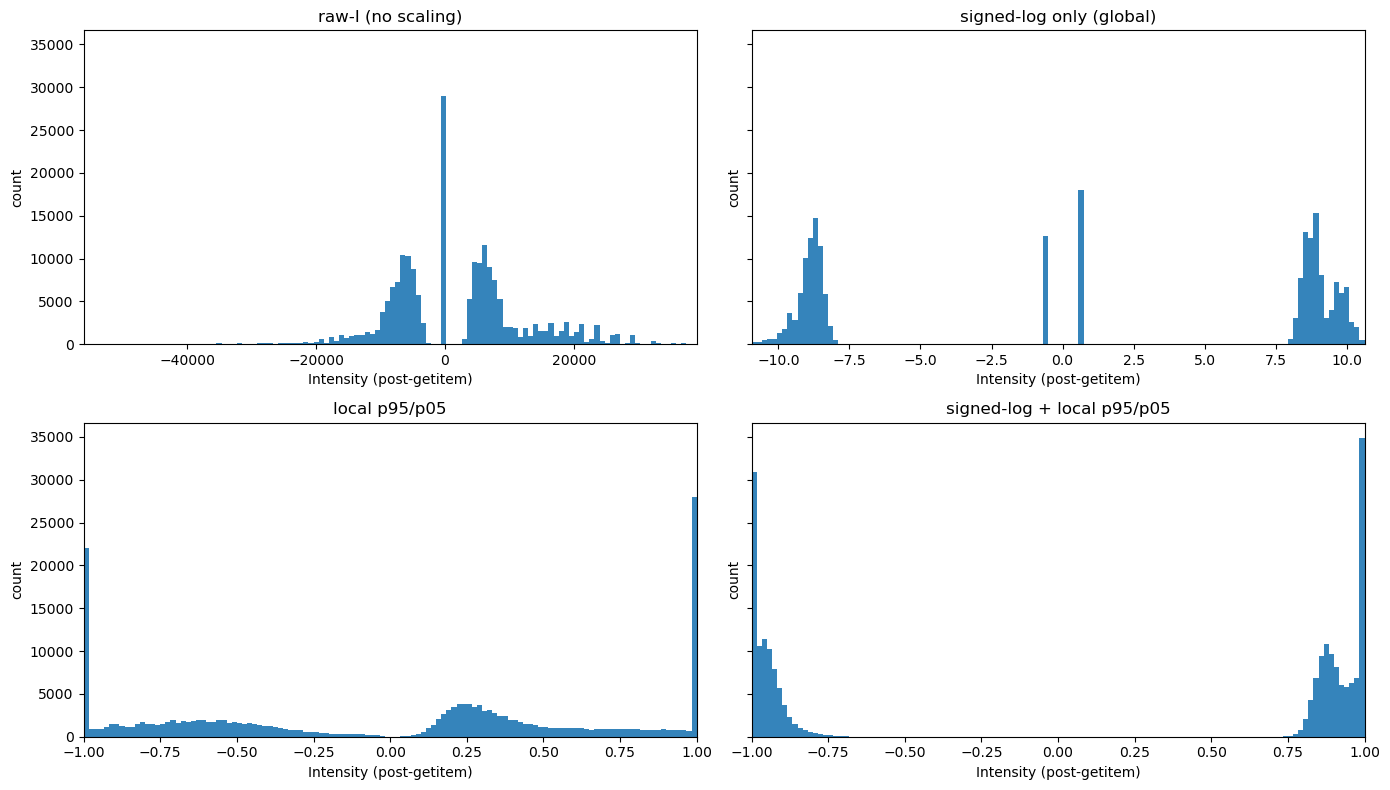

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
axes = axes.ravel()

for ax, (name, r) in zip(axes, results.items()):
    I = r["X"][:, 2]

    # robust x-range so one crazy tail doesn't ruin the plot
    lo, hi = np.percentile(I, [0.5, 99.5])
    ax.hist(I, bins=120, alpha=0.9, range=(lo, hi))

    ax.set_title(name)
    ax.set_xlabel("Intensity (post-getitem)")
    ax.set_ylabel("count")
    ax.set_xlim(lo, hi)

plt.tight_layout()
plt.show()


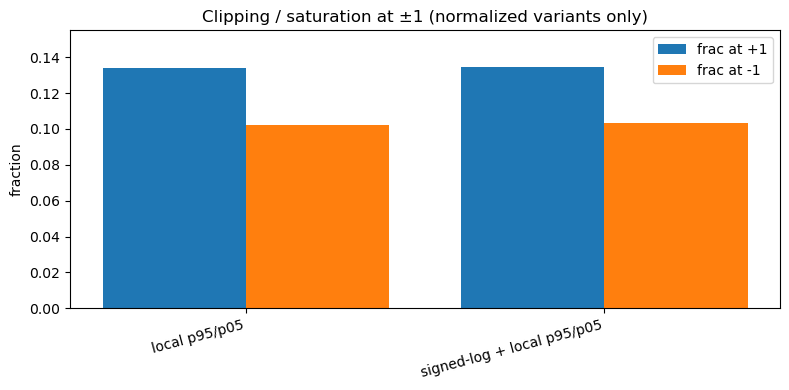

In [54]:
# keep only the normalized-to-[-1,1] variants
keep = {"local p95/p05", "signed-log + local p95/p05"}

names = [n for n in results.keys() if n in keep]
clip_pos = [results[n]["stats"]["clip_pos"] for n in names]
clip_neg = [results[n]["stats"]["clip_neg"] for n in names]

x = np.arange(len(names))
plt.figure(figsize=(8,4))
plt.bar(x - 0.2, clip_pos, width=0.4, label="frac at +1")
plt.bar(x + 0.2, clip_neg, width=0.4, label="frac at -1")
plt.xticks(x, names, rotation=15, ha="right")
plt.ylabel("fraction")
plt.title("Clipping / saturation at ±1 (normalized variants only)")
plt.ylim(0, max(clip_pos + clip_neg) * 1.15)
plt.legend()
plt.tight_layout()
plt.show()


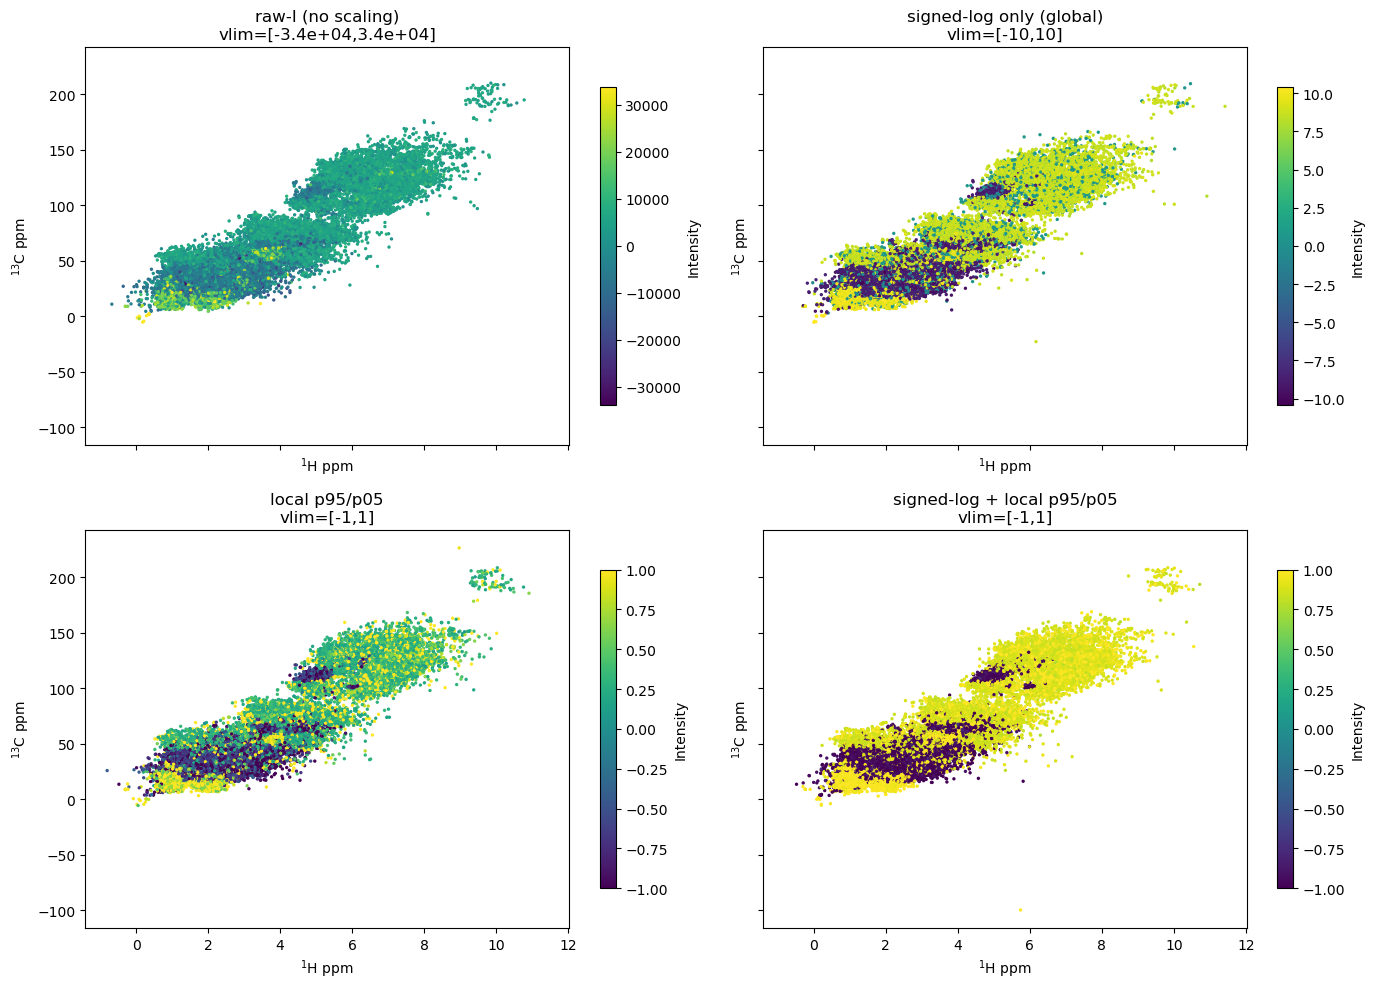

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (name, r) in zip(axes, results.items()):
    X = r["X"]
    idx = np.random.choice(X.shape[0], 50_000, replace=False)
    I = X[idx, 2]

    # robust symmetric limits
    lo, hi = np.percentile(I, [1, 99])
    m = max(abs(lo), abs(hi))
    vmin, vmax = -m, m

    sc = ax.scatter(X[idx, 1], X[idx, 0], s=2, c=I, vmin=vmin, vmax=vmax)
    ax.set_title(f"{name}\nvlim=[{vmin:.2g},{vmax:.2g}]")
    ax.set_xlabel(r"$^{1}$H ppm")
    ax.set_ylabel(r"$^{13}$C ppm")

    plt.colorbar(sc, ax=ax, shrink=0.8, label="Intensity")

plt.tight_layout()
plt.show()



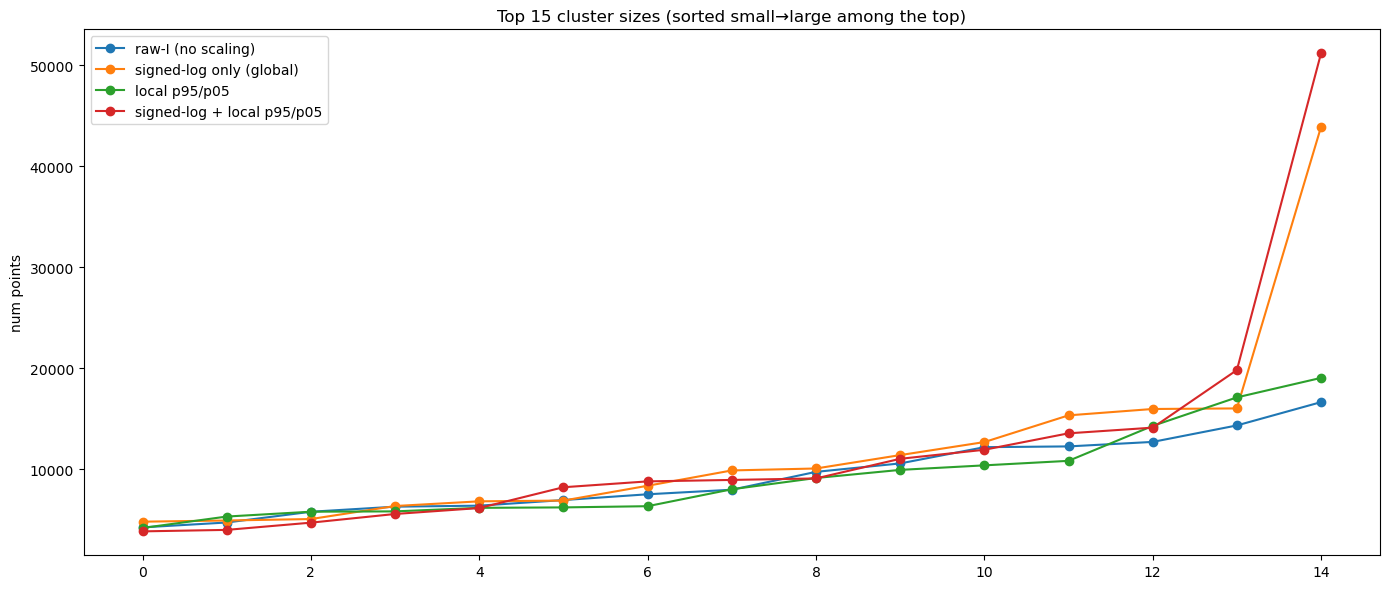

In [51]:
plt.figure(figsize=(14,6))
for name, r in results.items():
    labels = r["labels"]
    counts = np.bincount(labels, minlength=100)
    top = np.sort(counts)[-15:]
    plt.plot(top, marker="o", label=name)

plt.title("Top 15 cluster sizes (sorted small→large among the top)")
plt.ylabel("num points")
plt.legend()
plt.tight_layout()
plt.show()


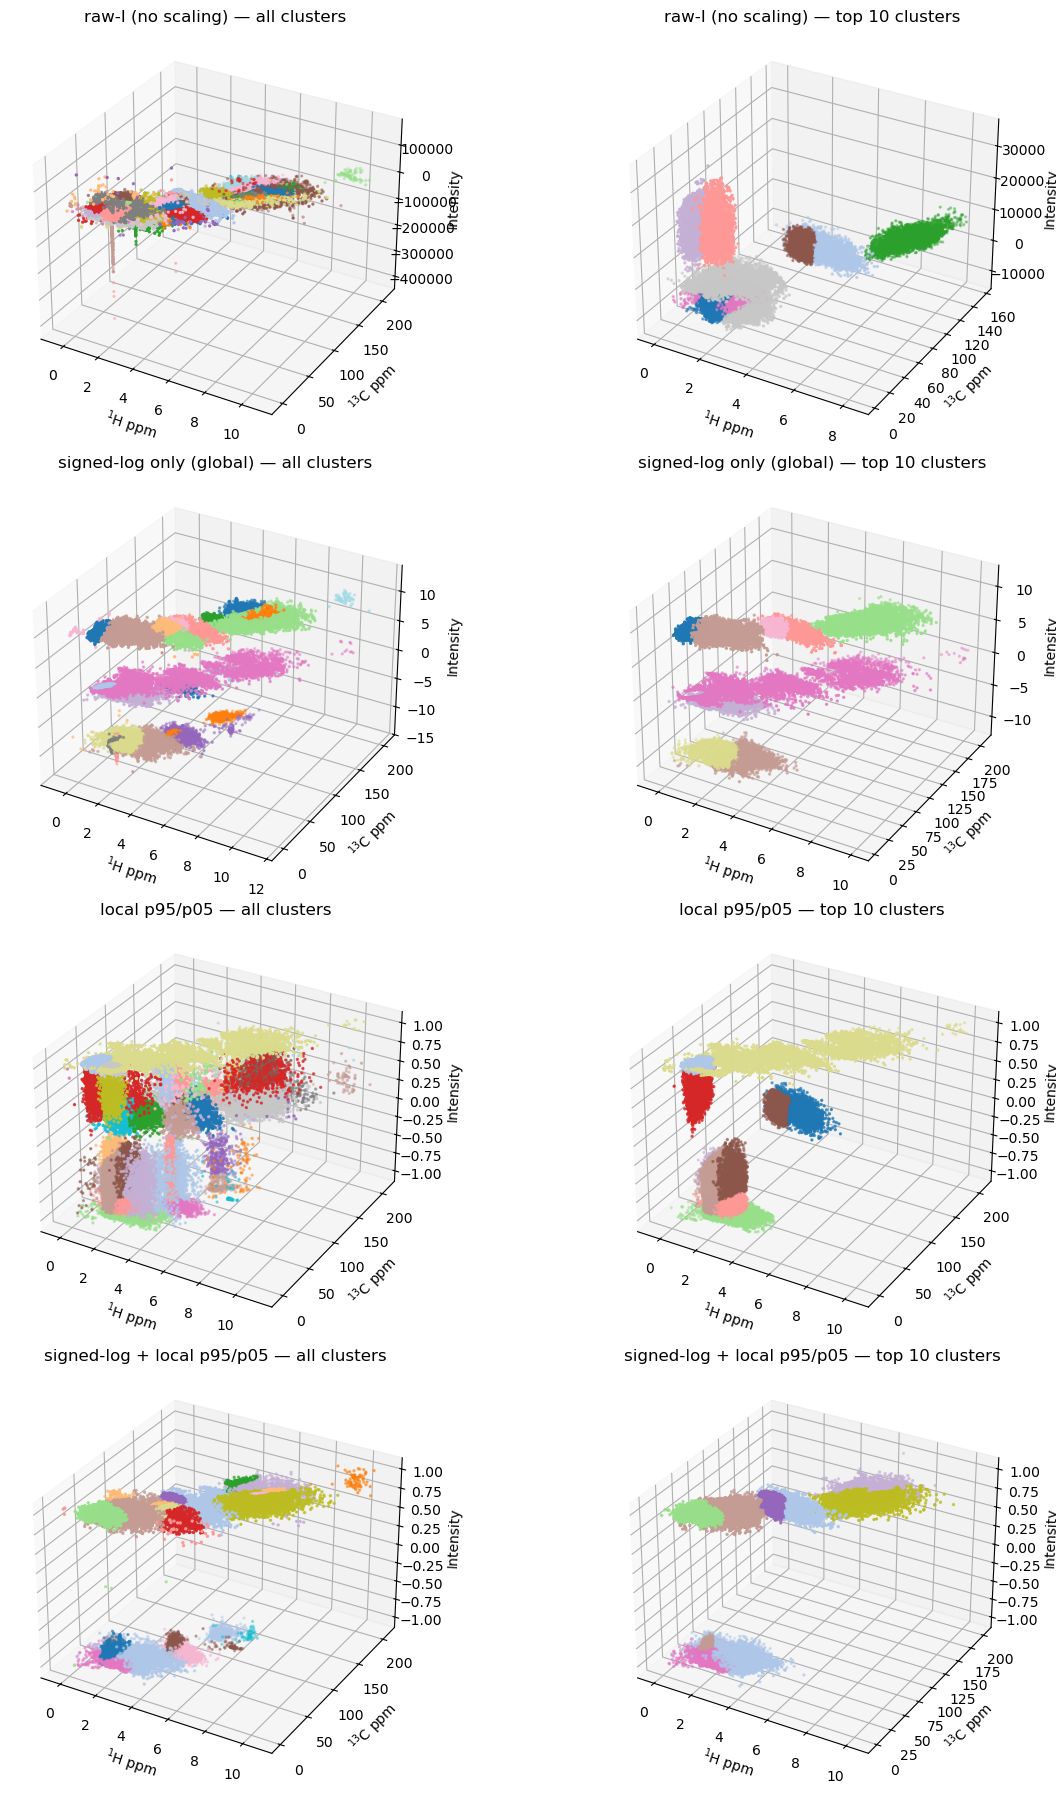

In [55]:
names = list(results.keys())

fig = plt.figure(figsize=(14, 18))

for i, name in enumerate(names):

    r = results[name]
    X = r["X"]
    labels = r["labels"]
    bgmm = r["bgmm"]

    K = bgmm.weights_.shape[0]
    cmap = plt.get_cmap("tab20", K)
    norm = BoundaryNorm(np.arange(-0.5, K + 0.5, 1), K)

    # --- subsample for plotting ---
    N = min(50_000, X.shape[0])
    idx_all = np.random.choice(X.shape[0], N, replace=False)

    # ==============
    # Column 1: All clusters
    # ==============
    ax1 = fig.add_subplot(len(names), 2, 2*i + 1, projection="3d")

    ax1.scatter(
        X[idx_all, 1],   # 1H
        X[idx_all, 0],   # 13C
        X[idx_all, 2],   # intensity
        s=2,
        c=labels[idx_all],
        cmap=cmap,
        norm=norm
    )

    ax1.set_title(f"{name} — all clusters")
    ax1.set_xlabel(r"$^{1}$H ppm")
    ax1.set_ylabel(r"$^{13}$C ppm")
    ax1.set_zlabel("Intensity")

    # ==============
    # Column 2: Top 10 clusters
    # ==============
    ax2 = fig.add_subplot(len(names), 2, 2*i + 2, projection="3d")

    active_ids = np.where(bgmm.weights_ > 1e-3)[0]
    top_ids = active_ids[np.argsort(-bgmm.weights_[active_ids])[:10]]

    mask = np.isin(labels, top_ids)
    idx_top_pool = np.where(mask)[0]

    if len(idx_top_pool) > 0:
        idx_top = np.random.choice(
            idx_top_pool,
            min(50_000, len(idx_top_pool)),
            replace=False
        )

        ax2.scatter(
            X[idx_top, 1],
            X[idx_top, 0],
            X[idx_top, 2],
            s=2,
            c=labels[idx_top],
            cmap=cmap,
            norm=norm
        )

    ax2.set_title(f"{name} — top 10 clusters")
    ax2.set_xlabel(r"$^{1}$H ppm")
    ax2.set_ylabel(r"$^{13}$C ppm")
    ax2.set_zlabel("Intensity")

plt.tight_layout()
plt.show()


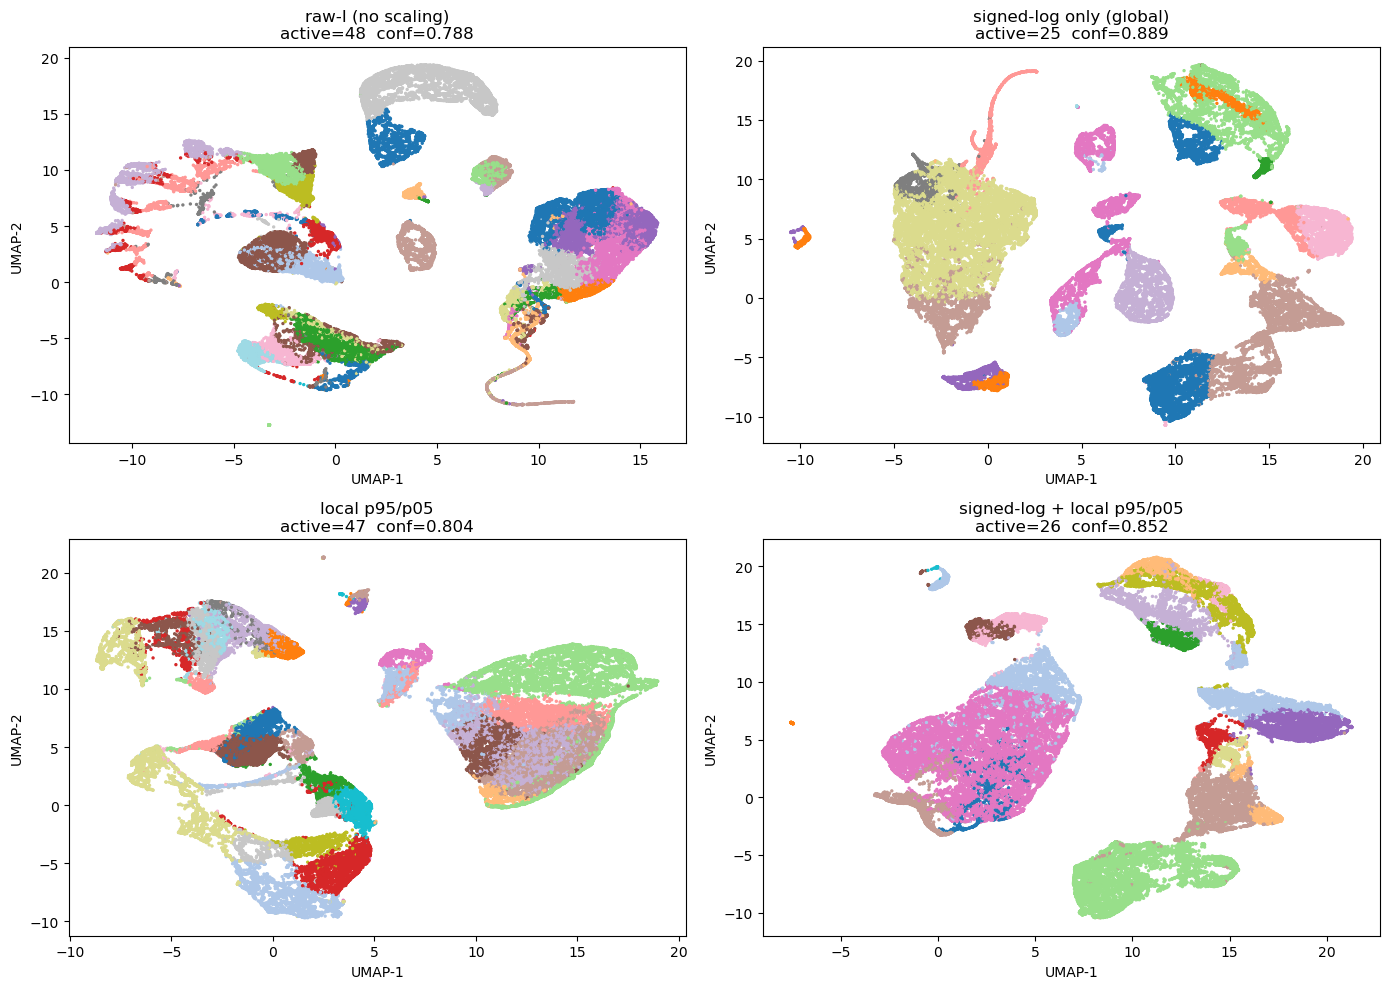

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for ax, (name, r) in zip(axes, results.items()):
    umap_idx, emb_sub = r["emb"]
    labels = r["labels"][umap_idx]
    K = r["bgmm"].weights_.shape[0]

    cmap = plt.get_cmap("tab20", K)
    norm = BoundaryNorm(np.arange(-0.5, K + 0.5, 1), K)

    ax.scatter(emb_sub[:,0], emb_sub[:,1], s=2, c=labels, cmap=cmap, norm=norm)
    ax.set_title(f"{name}\nactive={r['stats']['active_clusters']}  conf={r['stats']['mean_conf']:.3f}")
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

plt.tight_layout()
plt.show()
